In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
import copy
import pickle

import scipy
import numpy as np

from astropy.io import fits
from astropy.table import Table, Column, vstack
from astropy.stats import sigma_clipped_stats, sigma_clip

import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
fits_dir = '/Users/song/Downloads/for_jenny/'

sweep_list = glob.glob(fits_dir + '*.fits')

In [10]:
def sweep_flux_to_mag(catalog, band):
    """Convert flux into magnitude for DECaLS Sweep catalog."""
    flux_dered = catalog['FLUX_' + band.strip()] / catalog['MW_TRANSMISSION_' + band.strip()]
    return -2.5 * np.log10(flux_dered) + 22.5

def sweep_mag_err(catalog, band):
    """Estimate error of magnitude in certain band."""
    sn_ratio = catalog['FLUX_' + band.strip()] * np.sqrt(catalog['FLUX_IVAR_' + band.strip()])
    return 2.5 * np.log10(1. + 1. / sn_ratio)
    

def select_point_sources(sweep_file):
    """Select point sources from a SWEEP catalog."""
    print("\n# Dealing with catalog: {:s}".format(sweep_file))
    
    sweep = Table.read(sweep_file)
    print("# There are {:d} objects in the catalog".format(len(sweep)))
    
    psf_mask = sweep['TYPE'] == u'PSF '
    dup_mask = sweep['TYPE'] == u'DUP '
    print("# There are {:d} PSF objects".format(psf_mask.sum()))
    print("# There are {:d} DUP objects".format(dup_mask.sum()))
    
    psrc = copy.deepcopy(sweep[psf_mask | dup_mask])
    
    # Flag for point sources with detections in all GRZ bands
    use_mask = ((psrc['FLUX_G'] > 0) & (psrc['FLUX_R'] > 0) & (psrc['FLUX_Z'] > 0))
    print("# There are {:d} objects with useful flux in GRZ bands".format(use_mask.sum()))
    psrc.add_column(Column(data=use_mask, name='GRZ_DETECT'))
    
    # Flag for point sources with S/N > 5 detections in all GRZ bands
    good_mask = ((psrc['FLUX_G'] * np.sqrt(psrc['FLUX_IVAR_G']) > 5.) & 
                 (psrc['FLUX_R'] * np.sqrt(psrc['FLUX_IVAR_R']) > 5.) & 
                 (psrc['FLUX_Z'] * np.sqrt(psrc['FLUX_IVAR_Z']) > 5.))
    print("# There are {:d} objects with S/N>5 detections in GRZ bands".format(good_mask.sum()))
    psrc.add_column(Column(data=good_mask, name='GRZ_GOOD'))
    
    # Convert flux into magnitude after MW extinction correction
    psrc.add_column(Column(data=sweep_flux_to_mag(psrc, 'G'), name='MAG_G_DERED'))
    psrc.add_column(Column(data=sweep_flux_to_mag(psrc, 'R'), name='MAG_R_DERED'))
    psrc.add_column(Column(data=sweep_flux_to_mag(psrc, 'Z'), name='MAG_Z_DERED'))
    psrc.add_column(Column(data=sweep_flux_to_mag(psrc, 'W1'), name='MAG_W1_DERED'))
    psrc.add_column(Column(data=sweep_flux_to_mag(psrc, 'W2'), name='MAG_W2_DERED'))
    psrc.add_column(Column(data=sweep_flux_to_mag(psrc, 'W3'), name='MAG_W3_DERED'))
    psrc.add_column(Column(data=sweep_flux_to_mag(psrc, 'W4'), name='MAG_W4_DERED'))
    
    # Convert flux invar into magnitude error
    psrc.add_column(Column(data=sweep_mag_err(psrc, 'G'), name='MAG_G_ERR'))
    psrc.add_column(Column(data=sweep_mag_err(psrc, 'R'), name='MAG_R_ERR'))
    psrc.add_column(Column(data=sweep_mag_err(psrc, 'Z'), name='MAG_Z_ERR'))
    psrc.add_column(Column(data=sweep_mag_err(psrc, 'W1'), name='MAG_W1_ERR'))
    psrc.add_column(Column(data=sweep_mag_err(psrc, 'W2'), name='MAG_W2_ERR'))
    psrc.add_column(Column(data=sweep_mag_err(psrc, 'W3'), name='MAG_W3_ERR'))
    psrc.add_column(Column(data=sweep_mag_err(psrc, 'W4'), name='MAG_W4_ERR'))
    
    psrc_file = sweep_file.replace('.fits', '_psrc.fits')
    psrc.write(psrc_file, overwrite=True)
    
    return psrc

In [11]:
psrc_comb = vstack([select_point_sources(cat) for cat in sweep_list])


# Dealing with catalog: /Users/song/Downloads/for_jenny/sweep-330p000-340p005.fits
# There are 4724391 objects in the catalog
# There are 2202086 PSF objects
# There are 210 DUP objects
# There are 2104487 objects with useful flux in GRZ bands
# There are 876758 objects with S/N>5 detections in GRZ bands


<ipython-input-10-e1bea5bdb1c9>:4: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux_dered) + 22.5
<ipython-input-10-e1bea5bdb1c9>:4: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux_dered) + 22.5
<ipython-input-10-e1bea5bdb1c9>:9: RuntimeWarning: divide by zero encountered in true_divide
  return 2.5 * np.log10(1. + 1. / sn_ratio)
<ipython-input-10-e1bea5bdb1c9>:9: RuntimeWarning: invalid value encountered in log10
  return 2.5 * np.log10(1. + 1. / sn_ratio)



# Dealing with catalog: /Users/song/Downloads/for_jenny/sweep-330p005-340p010.fits
# There are 3939753 objects in the catalog
# There are 1896792 PSF objects
# There are 93 DUP objects
# There are 1808538 objects with useful flux in GRZ bands
# There are 844202 objects with S/N>5 detections in GRZ bands

# Dealing with catalog: /Users/song/Downloads/for_jenny/sweep-320m005-330p000.fits
# There are 5205828 objects in the catalog
# There are 2660478 PSF objects
# There are 195 DUP objects
# There are 2533130 objects with useful flux in GRZ bands
# There are 1200762 objects with S/N>5 detections in GRZ bands

# Dealing with catalog: /Users/song/Downloads/for_jenny/sweep-320p000-330p005.fits
# There are 5287534 objects in the catalog
# There are 2772375 PSF objects
# There are 212 DUP objects
# There are 2639762 objects with useful flux in GRZ bands
# There are 1285281 objects with S/N>5 detections in GRZ bands

# Dealing with catalog: /Users/song/Downloads/for_jenny/sweep-320p005-330p010

<ipython-input-10-e1bea5bdb1c9>:9: RuntimeWarning: divide by zero encountered in log10
  return 2.5 * np.log10(1. + 1. / sn_ratio)



# Dealing with catalog: /Users/song/Downloads/for_jenny/sweep-330m005-340p000.fits
# There are 4738984 objects in the catalog
# There are 2118507 PSF objects
# There are 281 DUP objects
# There are 2021420 objects with useful flux in GRZ bands
# There are 828951 objects with S/N>5 detections in GRZ bands

# Dealing with catalog: /Users/song/Downloads/for_jenny/sweep-330p010-340p015.fits
# There are 3916635 objects in the catalog
# There are 2023925 PSF objects
# There are 221 DUP objects
# There are 1933643 objects with useful flux in GRZ bands
# There are 909853 objects with S/N>5 detections in GRZ bands

# Dealing with catalog: /Users/song/Downloads/for_jenny/sweep-320p010-330p015.fits
# There are 4600477 objects in the catalog
# There are 2678463 PSF objects
# There are 210 DUP objects
# There are 2548841 objects with useful flux in GRZ bands
# There are 1398154 objects with S/N>5 detections in GRZ bands


In [12]:
print(len(psrc_comb), psrc_comb['GRZ_DETECT'].sum(), psrc_comb['GRZ_GOOD'].sum())

18771721 17875797 8533198


Text(0.5, 0, '$\\rm Magnitude$')

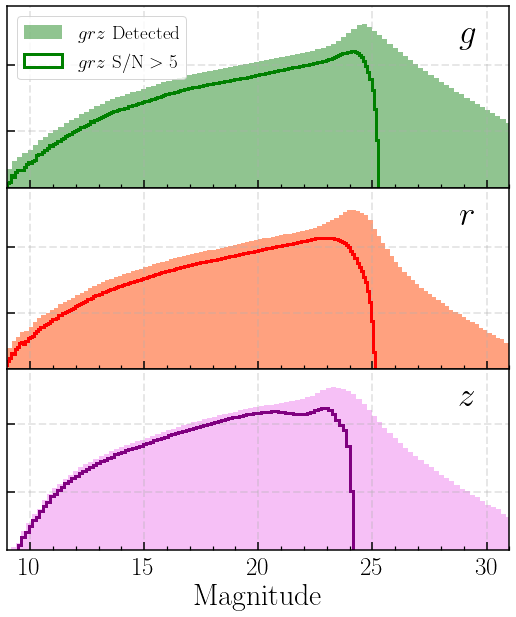

In [13]:
fig = plt.figure(figsize=(9, 10))
plt.subplots_adjust(wspace=0, hspace=0)

ax1 = plt.subplot(311)
ax1.set_yscale('log')
ax1.grid(linestyle='--', linewidth=2, alpha=0.3)
_ = ax1.hist(psrc_comb['MAG_G_DERED'][psrc_comb['GRZ_DETECT']], bins=200, 
             density=False, alpha=0.5, label=r'$grz\ \rm Detected$', 
             color='forestgreen')
_ = ax1.hist(psrc_comb['MAG_G_DERED'][psrc_comb['GRZ_GOOD']], bins=200, 
             density=False, histtype='step', linewidth=3, label=r'$grz\ {\rm S/N} > 5$',
             color='green')
ax1.legend(loc='best', fontsize=19)
ax1.set_xlim(9, 31)
ax1.set_ylim(20, 6e6)
ax1.xaxis.set_ticklabels([])
ax1.yaxis.set_ticklabels([])
ax1.text(0.9, 0.8, r'$g$', fontsize=35, transform=ax1.transAxes)

ax2 = plt.subplot(312)
ax2.set_yscale('log')
ax2.grid(linestyle='--', linewidth=2, alpha=0.3)
_ = ax2.hist(psrc_comb['MAG_R_DERED'][psrc_comb['GRZ_DETECT']], bins=200, 
             density=False, alpha=0.5, label=r'$grz\ \rm Detected$', 
             color='orangered')
_ = ax2.hist(psrc_comb['MAG_R_DERED'][psrc_comb['GRZ_GOOD']], bins=200, 
             density=False, histtype='step', linewidth=3, label=r'$grz\ {\rm S/N} > 5$',
             color='red')
ax2.set_ylim(20, 6e6)
ax2.set_xlim(9, 31)
ax2.xaxis.set_ticklabels([])
ax2.yaxis.set_ticklabels([])
ax2.text(0.9, 0.8, r'$r$', fontsize=35, transform=ax2.transAxes)

ax3 = plt.subplot(313)
ax3.set_yscale('log')
ax3.grid(linestyle='--', linewidth=2, alpha=0.3)
_ = ax3.hist(psrc_comb['MAG_Z_DERED'][psrc_comb['GRZ_DETECT']], bins=200, 
             density=False, alpha=0.5, label=r'$grz\ \rm Detected$', 
             color='violet')
_ = ax3.hist(psrc_comb['MAG_Z_DERED'][psrc_comb['GRZ_GOOD']], bins=200, 
             density=False, histtype='step', linewidth=3, label=r'$grz\ {\rm S/N} > 5$',
             color='purple')
ax3.set_ylim(20, 4e6)
ax3.set_xlim(9, 31)
ax3.yaxis.set_ticklabels([])
ax3.text(0.9, 0.8, r'$z$', fontsize=35, transform=ax3.transAxes)

ax3.set_xlabel(r'$\rm Magnitude$', fontsize=30)

In [21]:
psrc_good = psrc_comb[psrc_comb['GRZ_GOOD'] > 0]

col_use = [
    'BRICKID', 'OBJID', 'TYPE', 'RA', 'DEC', 'RA_IVAR', 'DEC_IVAR', 
    'NOBS_G', 'NOBS_R', 'NOBS_Z', 'NOBS_W1', 'NOBS_W2', 'NOBS_W3', 'NOBS_W4',
    'RCHISQ_G', 'RCHISQ_R', 'RCHISQ_Z', 'RCHISQ_W1', 'RCHISQ_W2', 'RCHISQ_W3', 'RCHISQ_W4',
    'FRACFLUX_G', 'FRACFLUX_R', 'FRACFLUX_Z', 'FRACFLUX_W1', 'FRACFLUX_W2', 'FRACFLUX_W3', 'FRACFLUX_W4',
    'FRACMASKED_G','FRACMASKED_R', 'FRACMASKED_Z', 'FRACIN_G', 'FRACIN_R', 'FRACIN_Z',
    'ANYMASK_G', 'ANYMASK_R', 'ANYMASK_Z', 'ALLMASK_G', 'ALLMASK_R', 'ALLMASK_Z',
    'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'PSFDEPTH_G','PSFDEPTH_R','PSFDEPTH_Z',
    'PSFDEPTH_W1', 'PSFDEPTH_W2',
    'SHAPEEXP_R', 'SHAPEEXP_R_IVAR', 'SHAPEEXP_E1', 'SHAPEEXP_E1_IVAR', 'SHAPEEXP_E2', 'SHAPEEXP_E2_IVAR',
    'GAIA_PHOT_G_MEAN_MAG', 'GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR',
    'GAIA_PHOT_BP_MEAN_MAG', 'GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR', 
    'GAIA_PHOT_RP_MEAN_MAG', 'GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR',
    'GAIA_ASTROMETRIC_EXCESS_NOISE', 'GAIA_DUPLICATED_SOURCE', 'GAIA_PHOT_BP_RP_EXCESS_FACTOR',
    'GAIA_ASTROMETRIC_SIGMA5D_MAX', 'GAIA_ASTROMETRIC_PARAMS_SOLVED',
    'PARALLAX', 'PARALLAX_IVAR', 'PMRA', 'PMRA_IVAR', 'PMDEC', 'PMDEC_IVAR',
    'MASKBITS', 
    'MAG_G_DERED', 'MAG_R_DERED', 'MAG_Z_DERED', 'MAG_W1_DERED', 'MAG_W2_DERED', 'MAG_W3_DERED', 'MAG_W4_DERED',
    'MAG_G_ERR', 'MAG_R_ERR', 'MAG_Z_ERR', 'MAG_W1_ERR', 'MAG_W2_ERR', 'MAG_W3_ERR', 'MAG_W4_ERR'
]

psrc_use = psrc_good[col_use]

In [24]:
psrc_fdfc = psrc_use[(psrc_use['NOBS_G'] > 2) & (psrc_use['NOBS_R'] > 2) & (psrc_use['NOBS_Z'] > 2)]

print(len(psrc_fdfc))

6397087


In [28]:
psrc_fdfc.write(os.path.join(fits_dir, 'dr8_320m05_340p15_psrc_good.fits'), overwrite=True)

In [26]:
gr_color = psrc_fdfc['MAG_G_DERED'] - psrc_fdfc['MAG_R_DERED']
rz_color = psrc_fdfc['MAG_R_DERED'] - psrc_fdfc['MAG_Z_DERED']

Text(0, 0.5, '$r-z\\ [\\rm mag]$')

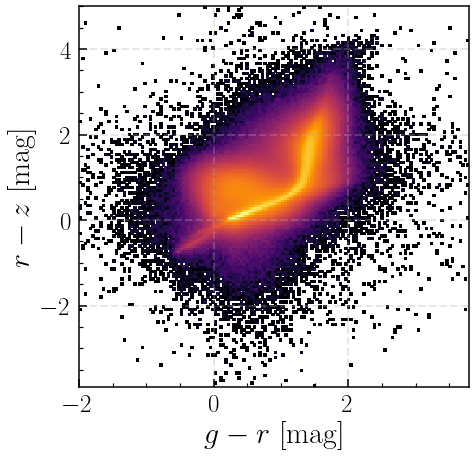

In [32]:
fig = plt.figure(figsize=(7, 7))

ax1 = plt.subplot(111)

# 2-D histogram
ax1.hist2d(
    gr_color, rz_color, bins=[150, 150], cmin=1, cmap='inferno',
    range=([-2, 3.8], [-3.9, 5]), norm=mpl.colors.LogNorm())

ax1.grid(linestyle='--', linewidth=2, alpha=0.3)
ax1.set_xlabel(r'$g-r\ [\rm mag]$', fontsize=30)
ax1.set_ylabel(r'$r-z\ [\rm mag]$', fontsize=30)

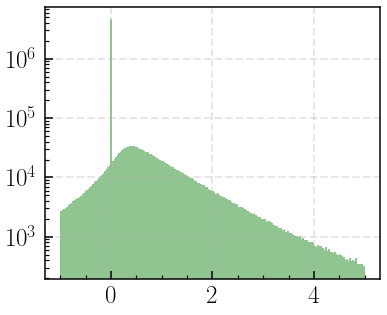

In [54]:
fig = plt.figure(figsize=(6, 5))

ax1 = plt.subplot(111)
ax1.set_yscale('log')
ax1.grid(linestyle='--', linewidth=2, alpha=0.3)

_ = ax1.hist(psrc_fdfc['PARALLAX'], bins=200, range=[-1, 5],
             density=False, alpha=0.5, label=r'$grz\ \rm Detected$', 
             color='forestgreen')

ax1.set_xlabel(r'$\rm $')

Text(0.5, 0, '${\\rm Reduced}\\ \\chi^2$')

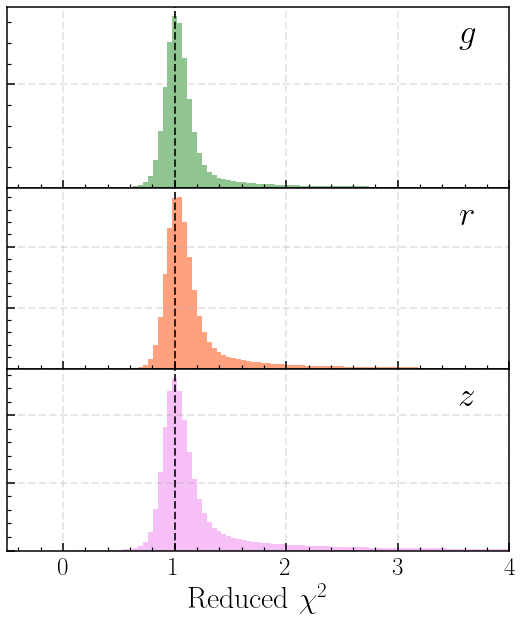

In [49]:
fig = plt.figure(figsize=(9, 10))
plt.subplots_adjust(wspace=0, hspace=0)

ax1 = plt.subplot(311)
ax1.grid(linestyle='--', linewidth=2, alpha=0.3)
_ = ax1.hist(psrc_fdfc['RCHISQ_G'], bins=250, range=[-1, 10],
             density=False, alpha=0.5, label=r'$grz\ \rm Detected$', 
             color='forestgreen')
ax1.axvline(1.0, linewidth=2, linestyle='--', c='k', alpha=0.8)
#ax1.legend(loc='best', fontsize=19)
ax1.set_xlim(-0.5, 4)
ax1.xaxis.set_ticklabels([])
ax1.yaxis.set_ticklabels([])
ax1.text(0.9, 0.8, r'$g$', fontsize=35, transform=ax1.transAxes)

ax2 = plt.subplot(312)
ax2.grid(linestyle='--', linewidth=2, alpha=0.3)
_ = ax2.hist(psrc_fdfc['RCHISQ_R'], bins=250, range=[-1, 10],
             density=False, alpha=0.5, label=r'$grz\ \rm Detected$', 
             color='orangered')
ax2.axvline(1.0, linewidth=2, linestyle='--', c='k', alpha=0.8)
ax2.set_xlim(-0.5, 4)
ax2.xaxis.set_ticklabels([])
ax2.yaxis.set_ticklabels([])
ax2.text(0.9, 0.8, r'$r$', fontsize=35, transform=ax2.transAxes)

ax3 = plt.subplot(313)
ax3.grid(linestyle='--', linewidth=2, alpha=0.3)
_ = ax3.hist(psrc_fdfc['RCHISQ_Z'], bins=250, range=[-1, 10],
             density=False, alpha=0.5, label=r'$grz\ \rm Detected$', 
             color='violet')
ax3.axvline(1.0, linewidth=2, linestyle='--', c='k', alpha=0.8)
ax3.set_xlim(-0.5, 4)
ax3.yaxis.set_ticklabels([])
ax3.text(0.9, 0.8, r'$z$', fontsize=35, transform=ax3.transAxes)

ax3.set_xlabel(r'${\rm Reduced}\ \chi^2$', fontsize=30)